<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbDataExplorationCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from datetime import datetime
from dateutil.parser import parse

In [3]:
def map_str_col_to_time(df, col):
  df[col] = df[col].map(lambda time: parse(time))

In [4]:
bulb_data = pd.read_csv('/content/drive/Shared drives/CMPE295B/InfluxData/2021-07-12_10_15-2021-07-12_10_15.csv', infer_datetime_format = True)
map_str_col_to_time(bulb_data, '_time')

# start and stop time are the total interval for the dataset
# this data was collected over 30 days at 1 hour intervals
bulb_data.drop(['_start', '_stop'], axis=1, inplace=True)

In [5]:
bulb_data.head()

,table,_time,_value,_field,_measurement,id,label
0,0,2021-06-12 18:00:00+00:00,NaN,brightness,bulb_reading,d073d55e535c,LIFX White 5E535C
1,0,2021-06-12 19:00:00+00:00,NaN,brightness,bulb_reading,d073d55e535c,LIFX White 5E535C
2,0,2021-06-12 20:00:00+00:00,NaN,brightness,bulb_reading,d073d55e535c,LIFX White 5E535C
3,0,2021-06-12 21:00:00+00:00,NaN,brightness,bulb_reading,d073d55e535c,LIFX White 5E535C
4,0,2021-06-12 22:00:00+00:00,NaN,brightness,bulb_reading,d073d55e535c,LIFX White 5E535C


In [6]:
bulb_data.count()

table           2163
_time           2163
_value           280
_field          2163
_measurement    2163
id              2163
label           2163
dtype: int64

In [7]:
### 3 different tables with equally-distributed samples
bulb_data['table'].value_counts()

1    721
2    721
0    721
Name: table, dtype: int64

In [8]:
### Only two unique ids - one has twice as many samples as the other?
### Assuming each light bulb has its own id?
bulb_data['id'].value_counts()

d073d55e535c    1442
d073d55df12f     721
Name: id, dtype: int64

In [9]:
bulb_data['_field'].value_counts()

brightness    2163
Name: _field, dtype: int64

In [11]:
bulb_data['_value'].value_counts()

1.000000    148
0.085400     44
0.447200     38
0.417387      3
0.968750      3
0.983333      3
0.439747      3
0.982143      3
0.962963      3
0.916667      2
0.083953      2
0.928571      2
0.439354      2
0.430637      2
0.492448      2
0.083543      2
0.980392      2
0.435733      2
0.857143      2
0.976190      2
0.933333      1
0.433225      1
0.427757      1
0.956522      1
0.778746      1
0.439214      1
0.223600      1
0.972973      1
0.500000      1
0.972360      1
Name: _value, dtype: int64

In [12]:
bulb_data['label'].value_counts()

LIFX White 5E535C    721
Light1               721
Light2               721
Name: label, dtype: int64

In [13]:
# group by light bulb id and sum the number of nulls in the value column
# AKA the number of missing readings for each bulb
# 77.8% missing values for bulb d073d55df12f
# 61.1% missing values for bulb d073d55e535c
bulb_data.groupby(['id']).agg({ '_value': lambda x: x.isnull().sum() })

,_value
id,
d073d55df12f,561.0
d073d55e535c,1322.0


Inspect values for a specific light bulb

In [19]:
bulb_1_df = bulb_data.loc[bulb_data['id'] == 'd073d55e535c']
print(bulb_1_df['_time'].min(), bulb_1_df['_time'].max())

2021-06-12 18:00:00+00:00 2021-07-12 17:15:32.866158+00:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


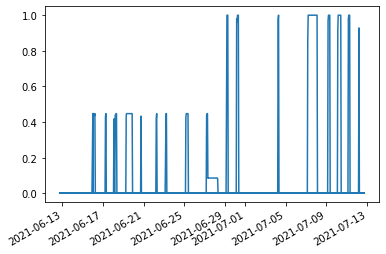

In [20]:
bulb_1_df['_value'] = bulb_1_df['_value'].fillna(0)
plt.plot(bulb_1_df['_time'], bulb_1_df['_value'])
plt.gcf().autofmt_xdate()

In [46]:
times = bulb_1_df['_time'].tolist()
start_time = times[0]
for timestamp in times[1:10]:
  diff_in_minutes = (timestamp - start_time).total_seconds() / 60
  if (diff_in_minutes != 60.0):
    print (diff_in_minutes)

120.0
180.0
240.0
300.0
360.0
420.0
480.0
540.0


Questions


1.   What does the table id correspond to? Is it one table per bulb?
2.   Why does one light bulb have twice as many samples as the other?
3.   Is there a temperature field available? -> **Yes, in Kelvin but this static download only includes brightness**
4.   Was there a third light bulb added? LIFX White 5E535C? -> **labels were switched halfway through the semester**
5.   Most readings are missing - can we assume the brightness was 0 for these readings, as in the light was turned off? -> **yes**
6.   One month's worth of data sampled every hour should = 730 records x 2 devices = 1,460 readings but there are 2,163?
7.   Brightness field is continuous - makes sense because the bulb is dimmable but some values are really specific such as 0.083953. Should check with Nithiya on how the lights are being turned on? I thought the app allowed fixed intervals for brightness (0, 0.25, 0.5. 0.75, 1.0), etc?
8.   Really large gaps where lights were off - for example bulb d073d55e535c was off from June 13th to June 17th? And again from July 1st to July 5th?
9.   Large gaps between some of the readings - as much as 9 hours between two readings -> **uploads only happen when the bulb is on**



Feature Engineering
1. Replace nan values with 0 - assume bulbs were off
2. Labels were changed halfway through the summer so LIFX White 5E535C corresponds to device d073d55e535c or Light 2
3. Uploads only happen when the bulb is turned ON - so gaps in readings need to be artifically filled with 0's (assumed bulb is turned OFF)